In [2]:
import gymnasium as gym
from gymnasium import spaces

import torch
from sb3_contrib.common.recurrent.policies import RecurrentActorCriticPolicy
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional
from datetime import datetime

In [3]:
reward_track=[]
class TradeEnv(gym.Env):
    def __init__(self, window_size=5, input_dim=25, day_length=96*3/2, df_list: list=None, starting_cash=1000):
        super(TradeEnv, self).__init__()
        self.action_space = spaces.Discrete(3) 
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(input_dim, ), dtype=np.float64)
        self.max_steps = day_length  # episode terminates when day ends
        self.window_size = window_size

        self.dataframes = [self.reformat_time_feature(self.calculate_macd(self.calculate_rsi(self.calculate_pct_change_and_vol(df)))).to_numpy() for df in df_list]

        self.currency_df = None
        self.position = 0
        self.step_counter = 0

        self.state = None
        self.current_price = 0

        self.profit = 0
        self.total_reward = 0
        self.shares_owned = 0
        self.position_open = 0
        self.last_buy_price = 0
        self.last_sell_price = 0
        self.cash = starting_cash
        self.initial_balance = starting_cash

    def step(self, action):
        self.position += 1
        self.step_counter += 1

        # terminated = self.step_counter == self.max_steps    # day ends
        terminated = self.profit < -5 or self.step_counter == self.max_steps
        truncated = self.position > self.currency_df.shape[0] - 1  # end of dataframe is reached

        reward = self.calculate_pnl(action)
        self.state = self.update_state(truncated)

        
        info = {"Profit": self.profit,
                "Cash": self.cash,
                "Shares Owned": self.shares_owned,
                "Last Buy Price": self.last_buy_price,
                "Last Sell Price": self.last_sell_price,
                "Position Open": self.position_open,
                "Total Reward": self.total_reward}
        
        # print(info)

        if terminated:
            reward_track.append(self.total_reward)

        return self.state, reward, terminated, truncated, info
    
    def update_state(self, truncated):
        inventory_state = np.array([self.cash, self.profit, self.shares_owned,
                                    self.last_buy_price, self.last_sell_price,
                                    self.position_open])
        
        position = self.position if not truncated else self.position - 1
    
        
        self.state = np.append(self.currency_df[position], inventory_state)
        return self.state
    

    def reset(self, seed: Optional[int] = None):
        super().reset(seed=seed)
        self.current_price = 0
        self.step_counter = 0

        self.profit = 0
        self.total_reward = 0
        self.shares_owned = 0
        self.position_open = 0
        self.last_buy_price = 0
        self.last_sell_price = 0
        self.cash = self.initial_balance

        self.currency_df = self.dataframes[np.random.randint(0, 3)]
        self.position = np.random.randint(self.currency_df.shape[0])

        inventory_state = np.array([self.cash, self.profit, self.shares_owned,
                                    self.last_buy_price, self.last_sell_price,
                                    self.position_open])

        self.state = np.append(self.currency_df[self.position], inventory_state)

        info = {'Profit': self.profit,
                'Cash': self.cash}

        return self.state, info
    

    def calculate_pnl(self, action):
        self.current_price = self.state[3]

        if action == 0: # buy
            if not self.position_open:
                self.position_open = 1
                self.last_buy_price = self.current_price
                self.shares_owned = self.cash / self.current_price 
                self.cash -= self.shares_owned * self.current_price
                reward = 0
            else:
                reward = -0.01
        
        if action == 1: # sell
            if self.position_open:
                self.last_sell_price = self.current_price
                reward = self.shares_owned * (self.current_price - self.last_buy_price)
                self.cash += self.shares_owned * self.current_price
                self.profit += reward
                self.position_open = 0
                self.shares_owned = 0
            else: 
                reward = -0.01

        if action == 2: # hold
            reward = 0

        self.total_reward += reward

        return reward

    def calculate_rsi(self, df):
        period = self.window_size
        df['delta'] = df['Close'].diff(1)
        df['gain'] = df['delta'].clip(lower=0)
        df['loss'] = df['delta'].clip(upper=0)
        avg_gain = df['gain'].ewm(com=period-1, adjust=False, min_periods = period).mean()
        avg_loss = abs(df['loss'].ewm(com=period-1, adjust=False, min_periods = period).mean())
        rs = avg_gain / avg_loss
        df['rsi'] = 100 - (100 / (1 + rs))
        df.drop(columns=['delta', 'gain', 'loss'], inplace=True)
        return df

    def calculate_macd(self, df, fast=3, slow=5, signal=2):
        fast_ema = df['Close'].ewm(span=fast, min_periods=fast, adjust=False).mean()
        slow_ema = df['Close'].ewm(span=slow, min_periods=slow, adjust=False).mean()
        df['macd'] = fast_ema - slow_ema
        df['signal_line'] = df['macd'].ewm(span=signal, min_periods=fast, adjust=False).mean()
        df['macd_h'] = df['macd'] - df['signal_line']
        df.dropna(inplace=True)
        return df
    
    def reformat_time_feature(self, df):
        df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x))
        df['Time'] = df['Time'].dt.hour * 60 + df['Time'].dt.minute
        df['cos_time'] = np.cos(2 * np.pi * df['Time'] / 1440)
        df['sin_time'] = np.sin(2 * np.pi * df['Time'] / 1440)
        df.drop(columns='Time', inplace=True)
        return df
    
    def calculate_pct_change_and_vol(self, df):
        df[['o_pct', 'h_pct', 'l_pct', 'c_pct', 'v_pct', 't_pct']] = df[['Open', 'High', 'Low', 'Close', 'Volume', 'Trades']].pct_change()
        df['vol'] = df['High'] / df['Low']
        df.dropna(inplace=True)
        return df

In [4]:
currencies = ['AVAX', 'DOT', 'SOL']
df_list = []
for currency in currencies:
    df = pd.read_csv(f'trading_train_data/{currency}_train.csv')
    df_list.append(df)

In [5]:
env = make_vec_env(TradeEnv, n_envs=1, env_kwargs={'df_list': df_list})

model = RecurrentPPO(RecurrentActorCriticPolicy, 
                    env, 
                    verbose=1, 
                    batch_size=32, 
                    n_steps=200, 
                    learning_rate=0.0001,
                    gamma=0.9, 
                    gae_lambda=0.95, 
                    clip_range=0.2,
                    clip_range_vf=None,
                    ent_coef=0.01, 
                    vf_coef=0.5, 
                    max_grad_norm=0.5,
                    target_kl=None, 
                    tensorboard_log=None,
                    seed=42, 
                    device="auto", 
                    _init_setup_model=True,
                    policy_kwargs={
                        'lstm_hidden_size': 128, 
                        'n_lstm_layers': 1,
                        'net_arch': dict(pi=[256, 128], vf=[128]),
                        'activation_fn': torch.nn.Tanh
                    })

model.learn(total_timesteps=50000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.3     |
|    ep_rew_mean     | -8.77    |
| time/              |          |
|    fps             | 1273     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 31.7         |
|    ep_rew_mean          | -9.21        |
| time/                   |              |
|    fps                  | 280          |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 400          |
| train/                  |              |
|    approx_kl            | 0.0010011723 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -0.00133     

1.881104732068146


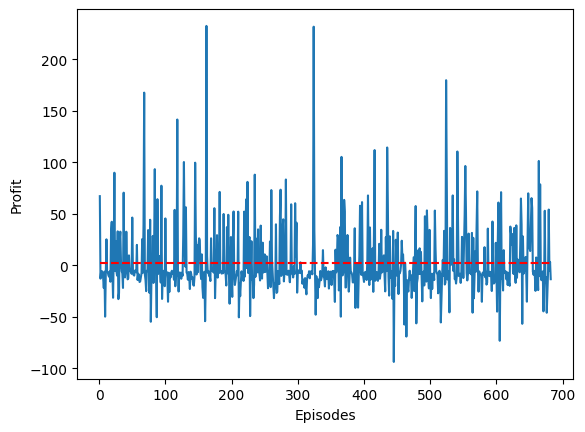

In [8]:
average = [sum(reward_track)/len(reward_track)]*len(reward_track)
print(average[0])
y=[0]*len(reward_track)
for i in range(1, len(reward_track)+1):
    y[i-1] = i
plt.figure()
plt.plot(y, reward_track)
plt.plot(y, average, 'r', linestyle="dashed")
plt.xlabel("Episodes")
plt.ylabel("Profit")
plt.show()
# plt.plot(reward_track)
# plt.xlabel("Episodes")
# plt.ylabel("Rewards")
# plt.show()
# print(sum(reward_track)/len(reward_track))

In [6]:
model.save("final_bot")
del model
model = RecurrentPPO.load("final_bot")

--------------------------START:-------------------------
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 0 - Profit: 0
Action: 2 - Profit: 0
Action: 0 - Profit: 0
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 0 - Profit: 0
Action: 2 - Profit: 0
Action: 2 - Profit: 0
Action: 1 - Profit: 12.596221133660007
Action: 0 - Profit: 12.596221133660007
Action: 0 - Profit: 12.596221133660007
Action: 0 - Profit: 12.596221133660007
Action: 1 - Profit: 16.79206182896514
Action: 0 - Profit: 16.79206182896514
Action: 0 - Profit: 16.79206182896514
Action: 2 - Profit: 16.79206182896514
Action: 0 - Profit: 16.79206182896514
Action: 2 - Profit: 16.79206182896514
Action: 1 - Profit: 13.312280645430082
Action: 0 - Profit: 13.312280645430082
Action: 1 - Profit: 21.584217630290805
Action: 0 - Profit: 21.584217630290805
Action: 1 - Profit: 22.968478087784394
Action: 0 - Profit: 22.968478087784394
Action: 1 - Profit: 23.658740218747795

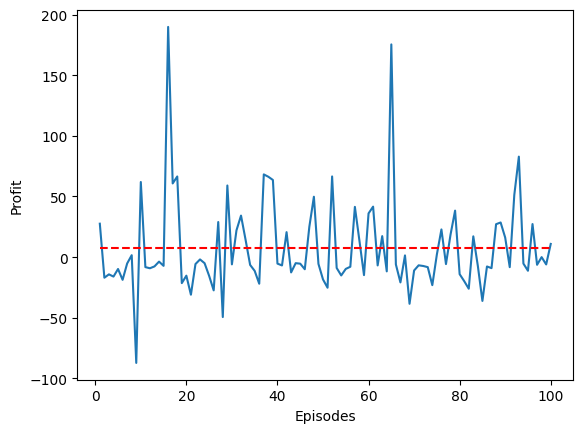

In [13]:
currencies = ['AVAX', 'DOT', 'SOL']
df_list = []
for currency in currencies:
    df = pd.read_csv(f'trading_train_data/{currency}_train.csv')
    df_list.append(df)

model = RecurrentPPO.load("trade_test_bot")

# Create a test environmant
env = TradeEnv(df_list=df_list)
# Create the required variables for calculation
done = False
truncated = False

# Predict the test values with the trained model

ep_profit = []
for i in range(100):
    obs, _ = env.reset()
    print("--------------------------START:-------------------------")
    while not done and not truncated:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, done, truncated, info = env.step(action)

        print(f"Action: {action} - Profit: {info['Profit']}")
    ep_profit.append(info['Profit'])
    done = False
    truncated = False
    print("---------------------------END:--------------------------")

print(ep_profit)
print(sum(ep_profit)/len(ep_profit))
average = [sum(ep_profit)/len(ep_profit)]*len(ep_profit)
y=[0]*len(ep_profit)
for i in range(1, len(ep_profit)+1):
    y[i-1] = i
plt.figure()
plt.plot(y, ep_profit, )
plt.plot(y, average, 'r', linestyle="dashed")
plt.xlabel("Episodes")
plt.ylabel("Profit")
plt.show()

Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 1 - Profit: 0
Action: 0 - Profit: 0
Action: 1 - Profit: 2.1186440677967533
Action: 1 - Profit: 2.1186440677967533
Action: 1 - Profit: 2.1186440677967533
Action: 1 - Profit: 2.1186440677967533
Action: 1 - Profit: 2.1186440677967533
Action: 0 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 2 - Profit: 2.1186440677967533
Action: 0 - Profit: 2.1186440677967533
Action: 0 - Profit: 2.1186440

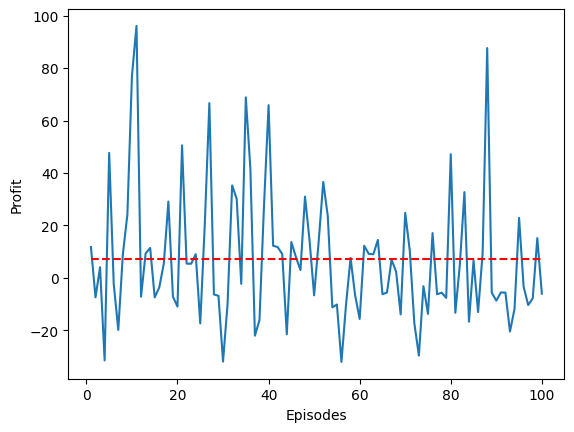

In [10]:
currencies = ['AVAX', 'DOT', 'SOL']
df_list = []
for currency in currencies:
    df = pd.read_csv(f'trading_test_data/{currency}USD_15.csv', names=['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Trades'])
    df_list.append(df)
    
test_env = TradeEnv(df_list=df_list)

done = False
truncated = False

ep_profit = []
for i in range(100):
    obs, _ = test_env.reset()
    while not done and not truncated:
        action, _ = model.predict(obs, deterministic=True)
        obs, rewards, done, truncated, info = test_env.step(action)

        print(f"Action: {action} - Profit: {info['Profit']}")
    done=False
    truncated=False
    ep_profit.append(info['Profit'])

print(ep_profit)
print(sum(ep_profit)/len(ep_profit))
average = [sum(ep_profit)/len(ep_profit)]*len(ep_profit)
y=[0]*len(ep_profit)
for i in range(1, len(ep_profit)+1):
    y[i-1] = i
plt.figure()
plt.plot(y, ep_profit, )
plt.plot(y, average, 'r', linestyle="dashed")
plt.xlabel("Episodes")
plt.ylabel("Profit")
plt.show()

In [1]:
test_env.dataframes[0]

NameError: name 'test_env' is not defined